# BidMPH v2 Monitor <br> Antofagasta

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [3]:
CITY_ID = 4263
CITY_NAME = 'Antofagasta'
ORDER_TYPE = 'auto_econom'

In [4]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [5]:
start_date = '2025-05-01'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as Antofagasta_total_bids.csv


df0 ('Before')

In [6]:
start_date = '2025-05-01'
end_date = '2025-05-20'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:09+00:00 
 to 2025-05-20 23:59:59+00:00
df0 saved as Antofagasta_before_bids.csv


df1 ('Test')

In [7]:
start_date = '2025-05-21'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-21 00:00:14+00:00 
 to 2025-06-06 06:48:10+00:00
df1 saved as Antofagasta_test_bids.csv


## Process Data

In [8]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [9]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [10]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [11]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_90060/3278834597.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')


df1

In [12]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_90060/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [13]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

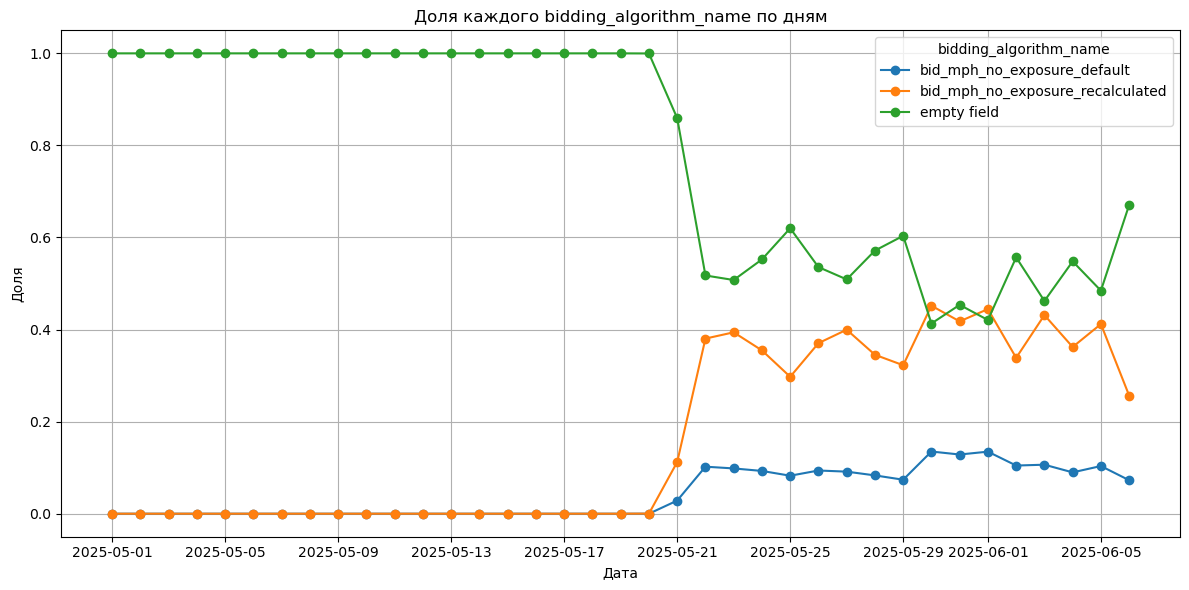

In [14]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [15]:
df0['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_recalculated',
       'bid_mph_no_exposure_default'], dtype=object)

In [16]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [17]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0,
 'bid_mph_no_exposure_recalculated': 0.0,
 'empty field': 1.0}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 1936568}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0446,
                'share': 0.2365},
 'between_0_1': {'done_share': 0.2779,
                 'share': 0.0454},
 'between_1_2': {'done_share': 0.1553,
                 'share': 0.0476},
 'match_first': {'done_share': 0.316,
                 'share': 0.0575},
 'match_second': {'done_share': 0.1832,
                  'share': 0.1583},
 'match_sp': {'done_share': 0.5442,
              'share': 0.3134},
 'match_third': {'done_share': 0.0959,
                 'share': 0.115}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                          

In [18]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.3396317609296446 0.057530125459059535 0.15826968120923202 0.11498382705900335


df1

In [19]:
df1['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_default',
       'bid_mph_no_exposure_recalculated'], dtype=object)

In [20]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [21]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0976,
 'bid_mph_no_exposure_recalculated': 0.3652,
 'empty field': 0.5372}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 835028}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.046,
                'share': 0.2583},
 'between_0_1': {'done_share': 0.2931,
                 'share': 0.042},
 'between_1_2': {'done_share': 0.1656,
                 'share': 0.0495},
 'match_first': {'done_share': 0.3346,
                 'share': 0.0547},
 'match_second': {'done_share': 0.1934,
                  'share': 0.1577},
 'match_sp': {'done_share': 0.5289,
              'share': 0.2926},
 'match_third': {'done_share': 0.1011,
                 'share': 0.1227}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': nan,
                  

In [22]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [23]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.0976,
 'bid_mph_no_exposure_recalculated': 0.3652,
 'empty field': 0.5372}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.5112,
 'len_2': 0.1526,
 'len_3': 0.3362,
 'total': 719431}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 0.0853,
                'share': 0.401},
 'between_0_1': {'done_share': 0.2645,
                 'share': 0.0121},
 'between_1_2': {'done_share': 0.1833,
                 'share': 0.0105},
 'match_first': {'done_share': 0.2783,
                 'share': 0.0837},
 'match_second': {'done_share': 0.1816,
                  'share': 0.078},
 'match_sp': {'done_share': 0.5159,
              'share': 0.3414},
 'match_third': {'done_share': 0.1046,
                 'share': 0.0422}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': 0.124,
       

## !

In [24]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 200
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [25]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [26]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

,1155433,1493667,496365
bid_uuid,01972b0f-2e87-7776-b8ea-e0ff8b0e719e,01972759-55f9-711a-b8f6-45bdce13b61d,019738a0-f068-7726-9749-f642c225ff3e
etr,558.0,1104.0,397.0
eta,300,180,60
price_highrate_value,3150.0,3850.0,2200.0
price_start_value,3400.0,3500.0,2200.0
bid_price_currency,4000.0,4000.0,1950.0
steps_recalc_default,"[3740.0000000000005, 4080.0, 4420.0]","[3850.0000000000005, 4200.0, 4550.0]","[2420.0, 2640.0, 2860.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3750.0],"[3850.0, 4200.0, 4250.0]","[2150.0, 2350.0, 2450.0]"
steps_real_perc,[1.1029411764705883],"[1.1, 1.2, 1.2142857142857142]","[0.9772727272727273, 1.0681818181818181, 1.113..."


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>

In [27]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,7,8,12,13,15,17,22,26,28,35,...,1566194,1566199,1566203,1566206,1566207,1566208,1566210,1566213,1566216,1566217
bid_uuid,019736c5-e44a-73af-9540-29405af164e3,01973647-3475-7286-93bd-74fa68aa9d2f,0197074d-d8e0-7abb-a516-b73162bf4f70,01973d74-2045-79eb-9213-a34c5e447df8,0197315c-3691-71db-a3d4-ed4f2d982528,019732d5-979d-76e1-97e5-7174209819d2,0197228b-4c7e-757d-9971-1ac59208db3c,01973cb3-50e7-766f-8fb9-df39a997d106,0196f96d-8342-70eb-94e2-04e2ac4c476b,01970175-6411-7e60-9e96-f6b5f9a8c98a,...,01972281-1dd9-76eb-ae2a-28883f59af18,019720f2-dcec-7179-bbdd-d58a07fe5286,01971f7b-fd79-78d2-b553-415dd82e643e,01972cbd-eaac-774e-9545-b319a05bc257,01971f7c-0ff7-7d8c-a861-df8682ae0d28,0197286b-68d0-798e-ab56-4b4f0a240e8b,01972513-1949-7c7c-bf5d-69a1caec204e,01972996-5250-7756-b98b-0ac687424678,0197263f-9b18-7f8b-ae56-0aac7239862e,0197286b-20ff-7568-91ac-908ce46ddb6a
etr,495.0,411.0,340.0,918.0,460.0,665.0,1412.0,598.0,995.0,974.0,...,1665.0,1361.0,1661.0,1598.0,1661.0,1399.0,606.0,843.0,1293.0,1399.0
eta,120,120,180,300,120,240,180,180,300,180,...,300,300,120,420,180,120,240,360,240,360
price_highrate_value,2700.0,2400.0,2350.0,4050.0,2250.0,4050.0,4750.0,2700.0,3600.0,5300.0,...,5700.0,6100.0,5000.0,5250.0,5000.0,4850.0,5100.0,4450.0,5350.0,4850.0
price_start_value,2700.0,2400.0,2000.0,4050.0,2250.0,4050.0,4750.0,2700.0,3600.0,5000.0,...,5000.0,6000.0,5500.0,5000.0,5500.0,5000.0,5000.0,5000.0,5000.0,5000.0
bid_price_currency,2700.0,3000.0,3000.0,6000.0,2250.0,4050.0,5250.0,3000.0,4000.0,7000.0,...,6500.0,7000.0,7000.0,6000.0,9000.0,5500.0,5000.0,5000.0,9990.0,6000.0
steps_recalc_default,"[2970.0000000000005, 3240.0, 3510.0]","[2640.0, 2880.0, 3120.0]","[2200.0, 2400.0, 2600.0]","[4455.0, 4860.0, 5265.0]","[2475.0, 2700.0, 2925.0]","[4455.0, 4860.0, 5265.0]","[5225.0, 5700.0, 6175.0]","[2970.0000000000005, 3240.0, 3510.0]","[3960.0000000000005, 4320.0, 4680.0]","[5500.0, 6000.0, 6500.0]",...,"[5500.0, 6000.0, 6500.0]","[6600.000000000001, 7200.0, 7800.0]","[6050.000000000001, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[6050.000000000001, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3000.0],[2650.0],"[2200.0, 2400.0, 2600.0]",[4500.0],[2500.0],[4500.0],[5250.0],[3000.0],[4000.0],"[5500.0, 5850.0]",...,"[5500.0, 6000.0, 6300.0]","[6600.0, 6850.0]",[5500.0],"[5500.0, 6000.0, 6150.0]",[6050.0],[5500.0],"[5500.0, 5800.0]","[5500.0, 6000.0, 6150.0]","[5500.0, 5900.0]",[5500.0]
steps_real_perc,[1.1111111111111112],[1.1041666666666667],"[1.1, 1.2, 1.3]",[1.1111111111111112],[1.1111111111111112],[1.1111111111111112],[1.105263157894737],[1.1111111111111112],[1.1111111111111112],"[1.1, 1.17]",...,"[1.1, 1.2, 1.26]","[1.1, 1.1416666666666666]",[1.0],"[1.1, 1.2, 1.23]",[1.1],[1.1],"[1.1, 1.16]","[1.1, 1.2, 1.23]","[1.1, 1.18]",[1.1]


In [28]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.938561
                                  True          0.061439
bid_mph_no_exposure_recalculated  False         0.163681
                                  True          0.836319
empty field                       False         0.276670
                                  True          0.723330
dtype: float64

In [29]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,481864,1565315,500909,369662,228224
bid_uuid,0196f473-5662-7efe-ac78-0dd4b6f78056,0197242f-25a9-7a02-9401-a077e4668662,01973691-ba20-725a-94e7-dc3a16a7e42c,01971e1f-b924-7866-a340-8ca52a727e28,01973960-a77d-76ec-a7d2-eb6a50a0e42b
etr,318.0,1239.0,265.0,367.0,964.0
eta,300,360,300,420,360
price_highrate_value,2300.0,5650.0,1950.0,2600.0,4550.0
price_start_value,2300.0,5000.0,1700.0,2600.0,4000.0
bid_price_currency,2300.0,5500.0,2050.0,2600.0,5000.0
steps_recalc_default,"[2530.0, 2760.0, 2990.0]","[5500.0, 6000.0, 6500.0]","[1870.0000000000002, 2040.0, 2210.0]","[2860.0000000000005, 3120.0, 3380.0]","[4400.0, 4800.0, 5200.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[2550.0],"[5500.0, 6000.0, 6250.0]","[1900.0, 2050.0, 2150.0]","[2900.0, 3100.0]","[4400.0, 4800.0, 5200.0]"
steps_real_perc,[1.108695652173913],"[1.1, 1.2, 1.25]","[1.1176470588235294, 1.2058823529411764, 1.264...","[1.1153846153846154, 1.1923076923076923]","[1.1, 1.2, 1.3]"


In [30]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)]['bid_uuid'].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [31]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [32]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,7,8,12,13,15,17,22,26,28,35,...,1566194,1566199,1566203,1566206,1566207,1566208,1566210,1566213,1566216,1566217
bid_uuid,019736c5-e44a-73af-9540-29405af164e3,01973647-3475-7286-93bd-74fa68aa9d2f,0197074d-d8e0-7abb-a516-b73162bf4f70,01973d74-2045-79eb-9213-a34c5e447df8,0197315c-3691-71db-a3d4-ed4f2d982528,019732d5-979d-76e1-97e5-7174209819d2,0197228b-4c7e-757d-9971-1ac59208db3c,01973cb3-50e7-766f-8fb9-df39a997d106,0196f96d-8342-70eb-94e2-04e2ac4c476b,01970175-6411-7e60-9e96-f6b5f9a8c98a,...,01972281-1dd9-76eb-ae2a-28883f59af18,019720f2-dcec-7179-bbdd-d58a07fe5286,01971f7b-fd79-78d2-b553-415dd82e643e,01972cbd-eaac-774e-9545-b319a05bc257,01971f7c-0ff7-7d8c-a861-df8682ae0d28,0197286b-68d0-798e-ab56-4b4f0a240e8b,01972513-1949-7c7c-bf5d-69a1caec204e,01972996-5250-7756-b98b-0ac687424678,0197263f-9b18-7f8b-ae56-0aac7239862e,0197286b-20ff-7568-91ac-908ce46ddb6a
etr,495.0,411.0,340.0,918.0,460.0,665.0,1412.0,598.0,995.0,974.0,...,1665.0,1361.0,1661.0,1598.0,1661.0,1399.0,606.0,843.0,1293.0,1399.0
eta,120,120,180,300,120,240,180,180,300,180,...,300,300,120,420,180,120,240,360,240,360
price_highrate_value,2700.0,2400.0,2350.0,4050.0,2250.0,4050.0,4750.0,2700.0,3600.0,5300.0,...,5700.0,6100.0,5000.0,5250.0,5000.0,4850.0,5100.0,4450.0,5350.0,4850.0
price_start_value,2700.0,2400.0,2000.0,4050.0,2250.0,4050.0,4750.0,2700.0,3600.0,5000.0,...,5000.0,6000.0,5500.0,5000.0,5500.0,5000.0,5000.0,5000.0,5000.0,5000.0
bid_price_currency,2700.0,3000.0,3000.0,6000.0,2250.0,4050.0,5250.0,3000.0,4000.0,7000.0,...,6500.0,7000.0,7000.0,6000.0,9000.0,5500.0,5000.0,5000.0,9990.0,6000.0
steps_recalc_default,"[2970.0000000000005, 3240.0, 3510.0]","[2640.0, 2880.0, 3120.0]","[2200.0, 2400.0, 2600.0]","[4455.0, 4860.0, 5265.0]","[2475.0, 2700.0, 2925.0]","[4455.0, 4860.0, 5265.0]","[5225.0, 5700.0, 6175.0]","[2970.0000000000005, 3240.0, 3510.0]","[3960.0000000000005, 4320.0, 4680.0]","[5500.0, 6000.0, 6500.0]",...,"[5500.0, 6000.0, 6500.0]","[6600.000000000001, 7200.0, 7800.0]","[6050.000000000001, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[6050.000000000001, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3000.0],[2650.0],"[2200.0, 2400.0, 2600.0]",[4500.0],[2500.0],[4500.0],[5250.0],[3000.0],[4000.0],"[5500.0, 5850.0]",...,"[5500.0, 6000.0, 6300.0]","[6600.0, 6850.0]",[5500.0],"[5500.0, 6000.0, 6150.0]",[6050.0],[5500.0],"[5500.0, 5800.0]","[5500.0, 6000.0, 6150.0]","[5500.0, 5900.0]",[5500.0]
steps_real_perc,[1.1111111111111112],[1.1041666666666667],"[1.1, 1.2, 1.3]",[1.1111111111111112],[1.1111111111111112],[1.1111111111111112],[1.105263157894737],[1.1111111111111112],[1.1111111111111112],"[1.1, 1.17]",...,"[1.1, 1.2, 1.26]","[1.1, 1.1416666666666666]",[1.0],"[1.1, 1.2, 1.23]",[1.1],[1.1],"[1.1, 1.16]","[1.1, 1.2, 1.23]","[1.1, 1.18]",[1.1]


In [33]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.938561
                                  True          0.061439
bid_mph_no_exposure_recalculated  False         0.163681
                                  True          0.836319
empty field                       False         0.276670
                                  True          0.723330
dtype: float64

Before experiment

In [34]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,74531,496717,504526,505984,843354,844300,848022,848237,854149,855118,...,1097705,1561628,1565597,1568740,1571393,1719483,1733951,1902668,1904111,1909083
bid_uuid,0196eff5-e6a9-7123-a0b5-d860c617aeb9,0196ef8a-f9f2-7ce9-8b4b-bf13cd4c73c9,0196ef8b-05eb-7830-8da8-52ef84e45737,0196ef8b-0adc-7fb8-a0b0-c4240263a842,0196ef1d-af2d-7e66-bf8b-03bb6d4c620a,0196ef26-a683-7870-92ef-0b8cba0092fd,0196ef22-3a5a-7867-8c4f-259c5293c69d,0196ef23-e3ee-7e78-90c7-3e6a295ca0f2,0196ef1d-fbdb-7e66-8e81-07568a6c2518,0196ef26-8f12-7e7d-ad7f-e7f326d26b33,...,0196efac-559f-79f2-92c7-8b49b17e7895,0196ee7f-c0d0-7683-8aab-138aa59e0037,0196ee7f-c168-7d7a-89d5-7867435b0dbb,0196ee7f-c18f-7d7a-b983-00d724dcb708,0196ee7f-b9d0-7d7a-b2a3-aa769016fba8,0196ee75-d578-7a92-9008-b0feef847e0f,0196ee75-c9b1-7560-9dbf-4fa4e26ca472,0196efad-43a0-788a-9e28-5b22a4d9072a,0196efac-d591-7d5a-a998-7669e4fffab0,0196efad-a725-7f28-96ff-055637df8ce3
etr,689.0,856.0,856.0,856.0,232.0,232.0,232.0,232.0,232.0,232.0,...,2296.0,354.0,354.0,354.0,354.0,268.0,268.0,2563.0,2563.0,2563.0
eta,120,240,60,120,300,180,240,420,240,300,...,540,60,180,60,60,120,240,120,120,120
price_highrate_value,2700.0,2600.0,2600.0,2600.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,...,9050.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,9100.0,9100.0,9100.0
price_start_value,2700.0,2600.0,2600.0,2600.0,1700.0,1700.0,1700.0,1700.0,1700.0,1700.0,...,9050.0,2000.0,2000.0,2000.0,2000.0,2000.0,2000.0,9100.0,9100.0,9100.0
bid_price_currency,2700.0,2900.0,2600.0,4000.0,1900.0,3000.0,1900.0,2000.0,2500.0,1700.0,...,10050.0,2000.0,2500.0,2000.0,2000.0,2000.0,2000.0,10050.0,13000.0,10050.0
steps_recalc_default,"[2970.0000000000005, 3240.0, 3510.0]","[2860.0000000000005, 3120.0, 3380.0]","[2860.0000000000005, 3120.0, 3380.0]","[2860.0000000000005, 3120.0, 3380.0]","[1870.0000000000002, 2040.0, 2210.0]","[1870.0000000000002, 2040.0, 2210.0]","[1870.0000000000002, 2040.0, 2210.0]","[1870.0000000000002, 2040.0, 2210.0]","[1870.0000000000002, 2040.0, 2210.0]","[1870.0000000000002, 2040.0, 2210.0]",...,"[9955.0, 10860.0, 11765.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]","[2200.0, 2400.0, 2600.0]","[10010.0, 10920.0, 11830.0]","[10010.0, 10920.0, 11830.0]","[10010.0, 10920.0, 11830.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[3000.0],[2900.0],[2900.0],[2900.0],[1900.0],[1900.0],[1900.0],"[1900.0, 2000.0]",[1900.0],[1900.0],...,"[10000.0, 10050.0]",[2200.0],[2200.0],[2200.0],[2200.0],[2200.0],[2200.0],[10050.0],[10050.0],[10050.0]
steps_real_perc,[1.1111111111111112],[1.1153846153846154],[1.1153846153846154],[1.1153846153846154],[1.1176470588235294],[1.1176470588235294],[1.1176470588235294],"[1.1176470588235294, 1.1764705882352942]",[1.1176470588235294],[1.1176470588235294],...,"[1.1049723756906078, 1.1104972375690607]",[1.1],[1.1],[1.1],[1.1],[1.1],[1.1],[1.1043956043956045],[1.1043956043956045],[1.1043956043956045]


In [35]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         1.000000
bid_mph_no_exposure_recalculated  False         0.227273
                                  True          0.772727
empty field                       False         0.321015
                                  True          0.678985
dtype: float64

Affected bids (not steps)

In [36]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,1953182,1953183,1953184,1953185,1953186,1953187,1953188,1953189,1953190,1953191
bid_uuid,01969dc5-7985-73a7-a23b-e5957f04cebe,0196a13c-7e73-7911-8c85-cfd7bdda9b52,01969ef9-1433-7ce8-8421-ee814e07d138,0196a1ff-e4f0-7440-b3f4-6e7c44b5a9d9,01969e4b-b0f3-7bb0-9e1b-2667ec8ef204,0196a297-8885-79a8-8620-d3df0bb30cd7,0196a077-af2d-7e4f-bd55-695639bc2fb8,0196a113-f7af-71be-a115-660880b82ff0,0196a24e-e549-7527-a2bb-a884c3b27c30,0196a17b-7949-7a12-b998-f9d28ffd9a5d,...,01968db6-bbca-73b6-8705-b3f49904c603,01968dcc-4f1d-73fe-94fe-7b0b7b30942e,01968c50-0bc5-77c5-8958-6003f40ecef1,01968c74-744f-72cb-bc31-0c2b43780dcf,01968b8a-b03c-73ec-bd13-5cd2b8388769,01968d30-7e45-7e57-8944-6df833aee6b1,01968980-5b24-7818-aa10-7c135331d8f9,0196899f-e46c-7b74-9680-dc1a79a90365,01968a72-f72d-7215-8a55-1fa32638aa24,01968e5b-f715-7c6a-857e-87530b0e7bb5
etr,514.0,1116.0,786.0,1572.0,1260.0,1054.0,368.0,536.0,720.0,724.0,...,640.0,259.0,1414.0,216.0,793.0,692.0,470.0,454.0,629.0,868.0
eta,240,240,300,480,300,300,180,240,300,240,...,120,180,180,180,120,120,180,240,240,180
price_highrate_value,3050.0,4500.0,3750.0,5850.0,4800.0,5400.0,2150.0,2450.0,3450.0,3150.0,...,3100.0,2300.0,5150.0,1900.0,3700.0,3450.0,2950.0,3050.0,4200.0,4000.0
price_start_value,3050.0,4500.0,3750.0,6000.0,5050.0,5400.0,2150.0,2450.0,3050.0,3000.0,...,3000.0,2300.0,5000.0,1900.0,3500.0,3000.0,2950.0,3000.0,4200.0,4000.0
bid_price_currency,3050.0,4500.0,3750.0,6600.0,8000.0,5400.0,3000.0,2450.0,4000.0,3000.0,...,4000.0,3000.0,5500.0,1900.0,3500.0,3500.0,3000.0,3600.0,5000.0,5000.0
steps_recalc_default,"[3355.0000000000005, 3660.0, 3965.0]","[4950.0, 5400.0, 5850.0]","[4125.0, 4500.0, 4875.0]","[6600.000000000001, 7200.0, 7800.0]","[5555.0, 6060.0, 6565.0]","[5940.000000000001, 6480.0, 7020.0]","[2365.0, 2580.0, 2795.0]","[2695.0, 2940.0, 3185.0]","[3355.0000000000005, 3660.0, 3965.0]","[3300.0000000000005, 3600.0, 3900.0]",...,"[3300.0000000000005, 3600.0, 3900.0]","[2530.0, 2760.0, 2990.0]","[5500.0, 6000.0, 6500.0]","[2090.0, 2280.0, 2470.0]","[3850.0000000000005, 4200.0, 4550.0]","[3300.0000000000005, 3600.0, 3900.0]","[3245.0000000000005, 3540.0, 3835.0]","[3300.0000000000005, 3600.0, 3900.0]","[4620.0, 5040.0, 5460.0]","[4400.0, 4800.0, 5200.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[3400.0, 3700.0, 4000.0]","[4950.0, 5400.0, 5850.0]","[4150.0, 4500.0, 4900.0]","[6600.0, 7200.0, 7800.0]","[5300.0, 5800.0, 6250.0]","[5950.0, 6500.0, 7050.0]","[2400.0, 2600.0, 2800.0]","[2700.0, 2950.0, 3200.0]","[3400.0, 3700.0, 4000.0]","[3300.0, 3600.0, 3900.0]",...,"[3300.0, 3600.0, 3900.0]","[2550.0, 2800.0, 3000.0]","[5500.0, 6000.0, 6500.0]","[2100.0, 2300.0, 2500.0]","[3850.0, 4200.0, 4550.0]","[3300.0, 3600.0, 3900.0]","[3250.0, 3550.0, 3850.0]","[3050.0, 3300.0, 3600.0]","[4650.0, 5050.0, 5500.0]","[4400.0, 4800.0, 5200.0]"
steps_real_perc,"[1.1147540983606556, 1.2131147540983607, 1.311...","[1.1, 1.2, 1.3]","[1.1066666666666667, 1.2, 1.3066666666666666]","[1.1, 1.2, 1.3]","[1.0495049504950495, 1.1485148514851484, 1.237...","[1.1018518518518519, 1.2037037037037037, 1.305...","[1.1162790697674418, 1.2093023255813953, 1.302...","[1.1020408163265305, 1.2040816326530612, 1.306...","[1.1147540983606556, 1.2131147540983607, 1.311...","[1.1, 1.2, 1.3]",...,"[1.1, 1.2, 1.3]","[1.108695652173913, 1.2173913043478262, 1.3043...","[1.1, 1.2, 1.3]","[1.105263157894737, 1.2105263157894737, 1.3157...","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1016949152542372, 1.2033898305084745, 1.305...","[1.0166666666666666, 1.1, 1.2]","[1.1071428571428572, 1.2023809523809523, 1.309...","[1.1, 1.2, 1.3]"


In [37]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         1.000000
bid_mph_no_exposure_recalculated  False         0.681818
                                  True          0.318182
empty field                       False         0.613715
                                  True          0.386285
dtype: float64

Choose Cities Query

In [38]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [39]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

start_date = '2025-05-01'
end_date = '2025-05-19'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [40]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
4216,4263,auto_econom,192.339534,0.100,1823555,693275,0.380178,499725,77213,0.154511
4217,4263,auto_econom,192.339534,0.125,1823555,604447,0.331466,499725,58651,0.117367
4218,4263,auto_econom,192.339534,0.150,1823555,538817,0.295476,499725,49118,0.098290
4219,4263,auto_econom,192.339534,0.200,1823555,402671,0.220816,499725,29944,0.059921
4220,4263,auto_econom,192.339534,0.250,1823555,288746,0.158342,499725,15536,0.031089
4221,4263,auto_econom,192.339534,0.300,1823555,222475,0.122001,499725,10546,0.021104
4222,4263,auto_econom,192.339534,0.350,1823555,156606,0.085880,499725,4709,0.009423
4223,4263,auto_econom,192.339534,0.400,1823555,122088,0.066951,499725,3024,0.006051


OG bid approach

In [41]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [42]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4263
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [43]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [44]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [45]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,33320,33326,34094,34098,34099,34100,46692,46722,47089,47220,...,1642825,1642826,1642827,1642828,1642829,1642830,1642831,1642832,1642833,1642834
bid_uuid,0196ee75-c9b1-7560-9dbf-4fa4e26ca472,0196ee75-d578-7a92-9008-b0feef847e0f,0196ee7f-b9d0-7d7a-b2a3-aa769016fba8,0196ee7f-c0d0-7683-8aab-138aa59e0037,0196ee7f-c168-7d7a-89d5-7867435b0dbb,0196ee7f-c18f-7d7a-b983-00d724dcb708,0196ef1d-af2d-7e66-bf8b-03bb6d4c620a,0196ef1d-fbdb-7e66-8e81-07568a6c2518,0196ef22-3a5a-7867-8c4f-259c5293c69d,0196ef23-e3ee-7e78-90c7-3e6a295ca0f2,...,0197452e-ffd9-7640-a3a1-0039c5908331,0197452f-005c-7ade-93fe-258fca985ffa,0197452f-01b4-71d7-aaea-ce9bc537dd56,0197452f-024c-71d8-aa90-b1e949ac55b5,0197452f-02b8-7ade-a7cd-aeb10fcb8a64,0197452f-02ff-71d8-9fc4-27f94f84b56d,0197452f-035b-7640-a257-6fbc7656ac3a,0197452f-0452-71d8-9409-529dcff6efc2,0197452f-05d5-7640-b7ff-96768aa6d1e3,0197452f-07a8-7640-94f9-6ca08d640585
etr,268,268,354,354,354,354,232,232,232,232,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,240,120,60,60,180,60,300,240,240,420,...,120,180,120,240,360,180,60,420,180,180
price_highrate_value,200000.0,200000.0,200000.0,200000.0,200000.0,200000.0,170000.0,170000.0,170000.0,170000.0,...,335000.0,300000.0,350000.0,320000.0,335000.0,335000.0,300000.0,260000.0,400000.0,295000.0
price_start_value,200000,200000,200000,200000,200000,200000,170000,170000,170000,170000,...,335000,300000,350000,400000,335000,335000,300000,260000,400000,300000
bid_price_currency,200000,200000,200000,200000,250000,200000,190000,250000,190000,200000,...,400000,300000,450000,400000,335000,370000,300000,300000,500000,400000
steps_recalc_default,"[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[220000.00000000003, 240000.0, 260000.0]","[187000.00000000003, 204000.0, 221000.0]","[187000.00000000003, 204000.0, 221000.0]","[187000.00000000003, 204000.0, 221000.0]","[187000.00000000003, 204000.0, 221000.0]",...,"[368500.00000000006, 402000.0, 435500.0]","[330000.0, 360000.0, 390000.0]","[385000.00000000006, 420000.0, 455000.0]","[440000.00000000006, 480000.0, 520000.0]","[368500.00000000006, 402000.0, 435500.0]","[368500.00000000006, 402000.0, 435500.0]","[330000.0, 360000.0, 390000.0]","[286000.0, 312000.0, 338000.0]","[440000.00000000006, 480000.0, 520000.0]","[330000.0, 360000.0, 390000.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[220000],[220000],[220000],[220000],[220000],[220000],[190000],[190000],[190000],"[190000, 200000]",...,[370000],[330000],[385000],[440000],[370000],[370000],[330000],[290000],[440000],[330000]
steps_real_perc,[1.1],[1.1],[1.1],[1.1],[1.1],[1.1],[1.1176470588235294],[1.1176470588235294],[1.1176470588235294],"[1.1176470588235294, 1.1764705882352942]",...,[1.1044776119402986],[1.1],[1.1],[1.1],[1.1044776119402986],[1.1044776119402986],[1.1],[1.1153846153846154],[1.1],[1.1]


In [46]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.808178
                                  True          0.191822
bid_mph_no_exposure_recalculated  False         0.156328
                                  True          0.843672
empty field                       False         0.250040
                                  True          0.749960
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [47]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,0,2,3,4,5,6,9,10,11,16,...,1566198,1566200,1566202,1566204,1566205,1566209,1566211,1566212,1566214,1566215
bid_uuid,0196fbb2-efc8-78a3-a174-36eaa635a362,0196fa95-2dfe-730e-b76c-0de7598db4d5,0196feb5-6077-7254-9ee8-e67a0cd0cc04,0196fd34-5036-7c6d-8c2e-c5b60c161471,0196fd06-90f2-7eac-beea-777b746f30ba,019737e8-3d87-7743-a01f-63e9d2d735db,019704bf-5316-7157-ae43-aca3416307af,019708ec-9cd8-7118-8118-ea4672f06358,0197057e-6545-7099-b219-898b1c8d7ec7,01973166-918f-7204-81ba-7cd417f91c87,...,019726fe-46a9-79e7-9bef-3e6ef7208b0b,01972353-ed50-795e-a44a-fe8afe77c3ae,01972358-e9d2-7f68-b6e3-aa1b11a08c5c,01971fd0-59c2-7df5-8b4f-0c0a4191dc3e,0197250d-1ac5-771c-8403-f9196a6c3f44,01971fd0-4eab-7df5-be24-3134f4f18bda,019727a6-60b1-7509-b8e5-d4223f8c064d,01972aaf-cdee-7725-92be-92beb1943ebb,0197250d-335f-7c6c-9415-630cc3de5763,019727a5-1f17-7e82-80cb-1c0672340d60
etr,745.0,311.0,662.0,457.0,615.0,1358.0,312.0,658.0,380.0,598.0,...,1598.0,1097.0,835.0,539.0,1088.0,539.0,1338.0,1850.0,1088.0,1338.0
eta,180,180,180,240,180,120,240,300,180,180,...,180,180,120,180,420,240,120,180,300,300
price_highrate_value,3150.0,1800.0,2450.0,2300.0,2450.0,5650.0,2150.0,2850.0,2650.0,2300.0,...,4450.0,4450.0,4450.0,3800.0,4950.0,3800.0,5400.0,8700.0,4950.0,5400.0
price_start_value,3150.0,1800.0,2450.0,2300.0,2450.0,6000.0,2000.0,3850.0,2650.0,2300.0,...,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,6000.0,6000.0,5000.0,6000.0
bid_price_currency,5000.0,2000.0,3500.0,2300.0,3200.0,8000.0,2400.0,3850.0,3000.0,2300.0,...,6000.0,6000.0,5000.0,5000.0,7000.0,5000.0,8000.0,6500.0,6000.0,6500.0
steps_recalc_default,"[3465.0000000000005, 3780.0, 4095.0]","[1980.0000000000002, 2160.0, 2340.0]","[2695.0, 2940.0, 3185.0]","[2530.0, 2760.0, 2990.0]","[2695.0, 2940.0, 3185.0]","[6600.000000000001, 7200.0, 7800.0]","[2200.0, 2400.0, 2600.0]","[4235.0, 4620.0, 5005.0]","[2915.0000000000005, 3180.0, 3445.0]","[2530.0, 2760.0, 2990.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[6600.000000000001, 7200.0, 7800.0]","[6600.000000000001, 7200.0, 7800.0]","[5500.0, 6000.0, 6500.0]","[6600.000000000001, 7200.0, 7800.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[3500.0, 3800.0, 4100.0]","[2000.0, 2200.0, 2350.0]","[2700.0, 2950.0, 3200.0]","[2550.0, 2800.0, 3000.0]","[2700.0, 2950.0, 3200.0]","[6600.0, 7200.0, 7800.0]","[2200.0, 2400.0, 2600.0]","[4250.0, 4650.0, 5050.0]","[2950.0, 3200.0, 3450.0]","[2550.0, 2800.0, 3000.0]",...,"[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]","[6600.0, 7200.0, 7800.0]","[6050.0, 6600.0, 7150.0]","[5500.0, 6000.0, 6500.0]","[5500.0, 6000.0, 6500.0]"
steps_real_perc,"[1.1111111111111112, 1.2063492063492063, 1.301...","[1.1111111111111112, 1.2222222222222223, 1.305...","[1.1020408163265305, 1.2040816326530612, 1.306...","[1.108695652173913, 1.2173913043478262, 1.3043...","[1.1020408163265305, 1.2040816326530612, 1.306...","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.103896103896104, 1.2077922077922079, 1.3116...","[1.1132075471698113, 1.2075471698113207, 1.301...","[1.108695652173913, 1.2173913043478262, 1.3043...",...,"[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.1, 1.2, 1.3]","[1.0083333333333333, 1.1, 1.1916666666666667]","[1.1, 1.2, 1.3]","[0.9166666666666666, 1.0, 1.0833333333333333]"


In [48]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.899862
                                  True          0.100138
bid_mph_no_exposure_recalculated  False         0.962580
                                  True          0.037420
empty field                       False         0.939989
                                  True          0.060011
dtype: float64